In [ ]:
!python --version

Python 3.10.12


In [ ]:
# !pip install opencv-python>=3.4.2.17
!pip install libsvm>=3.23.0

In [ ]:
import collections
from itertools import chain
import urllib.request as request
import pickle

import numpy as np

import scipy
import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform
import skimage.color

import cv2

from libsvm import svmutil
from numpy import ndarray

In [ ]:
def load_scale_params(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [ ]:
# Tính local mean
def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2))
    return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
    return signal.convolve2d(image, kernel, 'same')

In [ ]:
# Tính local deviation
def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))

In [ ]:
# Tính MSCN coefficients
def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)

    return (image - local_mean) / (local_var + C)

In [ ]:
# Tính Generalized Gaussian Distribution (GGD)
def generalized_gaussian_dist(x, alpha, sigma):
    beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))

    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

In [ ]:
def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

In [ ]:
def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))

    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)

    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

In [ ]:
def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_sigma(x, alpha, filter = lambda z: z < 0):
        return np.sqrt(mean_squares_sum(x, filter))

    def estimate_mean(alpha, sigma_l, sigma_r):
        return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))

    alpha = estimate_alpha(x)
    sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
    sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)

    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = estimate_mean(alpha, sigma_l, sigma_r)

    return alpha, mean, sigma_l, sigma_r

In [ ]:
def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
    # Kiểm tra và chuyển đổi ảnh về grayscale nếu cần
    if len(image.shape) == 3:
        from skimage.color import rgb2gray
        image = rgb2gray(image)

    def calculate_features(coefficients_name, coefficients, accum=np.array([])):
        alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)

        if coefficients_name == 'mscn':
            var = (sigma_l ** 2 + sigma_r ** 2) / 2
            return [alpha, var, 0, 0]

        return [alpha, mean, sigma_l ** 2, sigma_r ** 2]

    mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)

    features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
     # Kiểm tra và làm phẳng các hệ số
    features = [np.ravel(coeff) for coeff in coefficients.values()]
    flatten_features = list(chain.from_iterable(features))
    return np.array(flatten_features)

In [ ]:
def load_image(file_path):
    image = cv2.imread(file_path)
    return image

def plot_histogram(x, label):
    n, bins = np.histogram(x.ravel(), bins=50)
    n = n / np.max(n)
    plt.plot(bins[:-1], n, label=label, marker='o')

Start testing

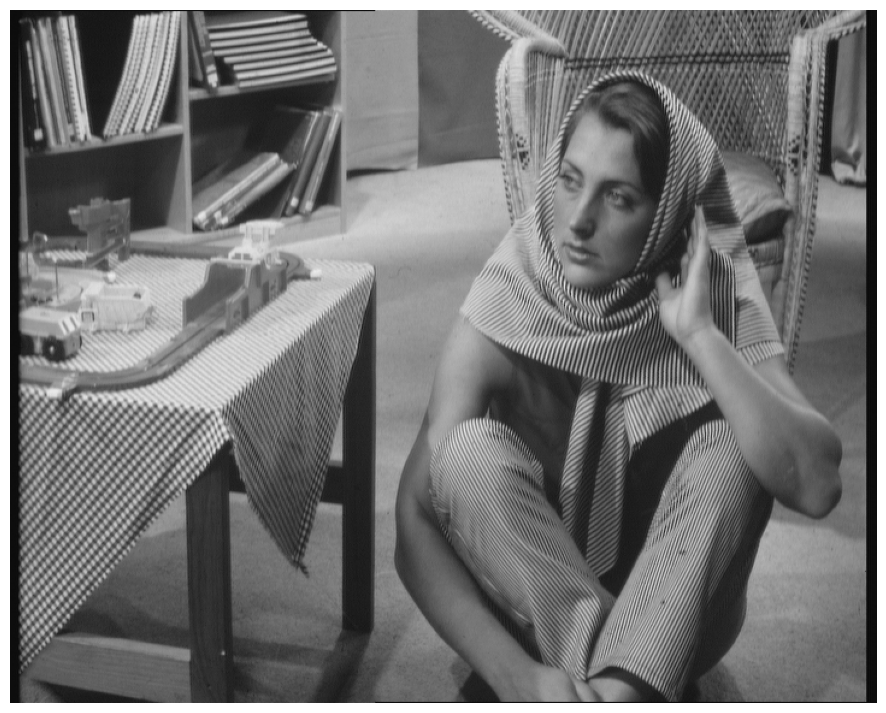

In [ ]:
# 1. Tải ảnh
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 9

url = '/content/drive/MyDrive/test chất lượng ảnh/barbara.png'
image = load_image(url)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# 2. Tính các hệ số
%%time

mscn_coefficients = calculate_mscn_coefficients(gray_image, 7, 7/6)
coefficients = calculate_pair_product_coefficients(mscn_coefficients)

CPU times: user 244 ms, sys: 6.36 ms, total: 251 ms
Wall time: 323 ms


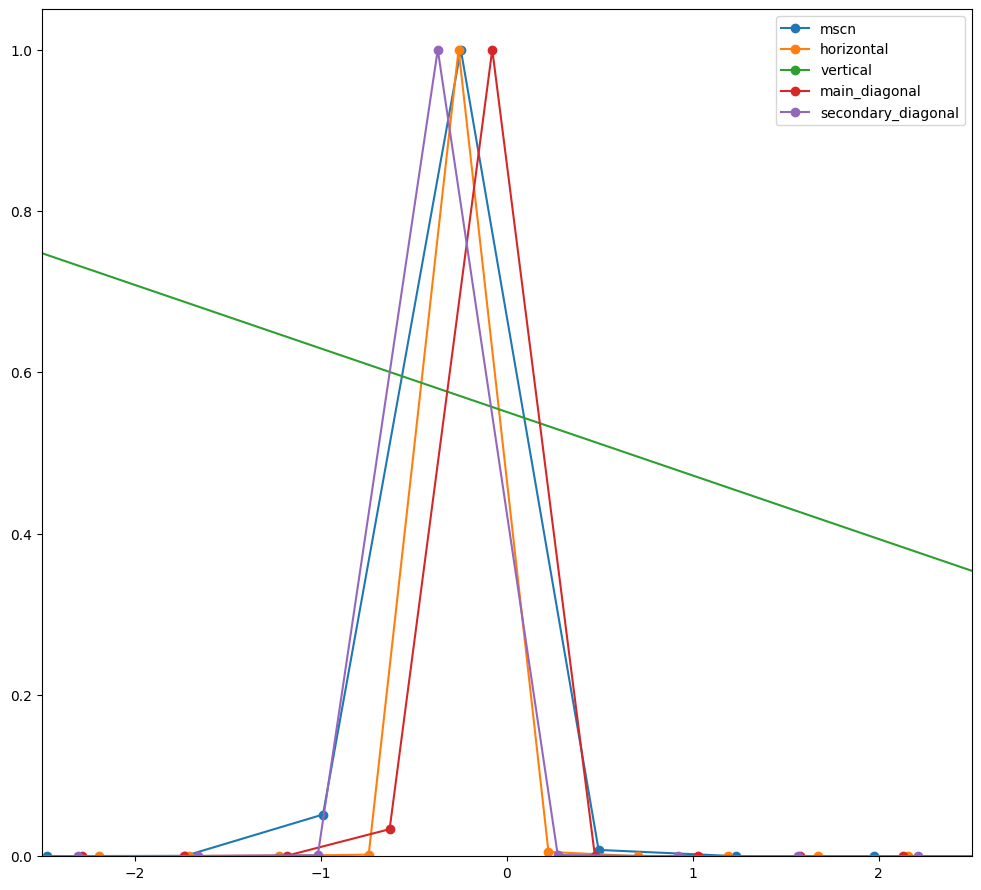

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 11

for name, coeff in coefficients.items():
    plot_histogram(coeff.ravel(), name)

plt.axis([-2.5, 2.5, 0, 1.05])
plt.legend()
plt.show()

In [ ]:
# 3. Khớp các hệ số vào phân phối Gaussian tổng quát
%%time

brisque_features = calculate_brisque_features(gray_image, kernel_size=7, sigma=7/6)

CPU times: user 752 ms, sys: 114 ms, total: 866 ms
Wall time: 1.31 s


In [ ]:
# 4. Điều chỉnh lại kích cỡ ảnh và tính toán các đặc trưng BRISQUE
%%time

downscaled_image = cv2.resize(gray_image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

brisque_features = np.concatenate((brisque_features, downscale_brisque_features))

CPU times: user 198 ms, sys: 22.3 ms, total: 220 ms
Wall time: 351 ms


In [ ]:
def patched_gen_svm_nodearray(xi, feature_max=None, isKernel=None):
    """
    A patched version of svmutil.gen_svm_nodearray to fix the scipy.ndarray issue.
    """
    # Check if xi is a list of numbers (not a list of dicts)
    if isinstance(xi, list) and all(isinstance(item, (int, float)) for item in xi):
        index_range = range(1, len(xi) + 1)  # Start from 1 for libsvm format
        x = []
        for i, val in zip(index_range, xi):
            x.append(svmutil.svm_node(index=i, value=val))
        return x, index_range

    # Otherwise, use the original logic (from svmutil)
    else:
        if isinstance(xi, dict):
            index_range = xi.keys()
        elif isinstance(xi, list) and isinstance(xi[0], dict):
            index_range = xi[0].keys()
        else:
            index_range = range(len(xi[0])) if isinstance(xi, list) else range(len(xi))

        if feature_max:
            index_range = filter(lambda j: j <= feature_max, index_range)

        if not isKernel:
            if isinstance(xi, list) and isinstance(xi[0], dict):
                xi_shift = 1  # If xi is a list of dictionary, shift index by 1
            else:
                xi_shift = 0  # Otherwise, no shift

        x = []
        for i, val in enumerate(xi):
            if isinstance(val, dict):
                for k, v in val.items():
                    if (feature_max and k <= feature_max) or not feature_max:
                        x.append(svmutil.svm_node(index=k + xi_shift, value=v))
            else:
                if (feature_max and i + 1 <= feature_max) or not feature_max:
                    x.append(svmutil.svm_node(index=i + 1 + xi_shift, value=val))  # index starts from 1

        return x, index_range

# Monkey patch the original function
svmutil.gen_svm_nodearray = patched_gen_svm_nodearray

In [ ]:
# 5. Chuẩn hóa các đặc trưng và đưa vào SVR
def scale_features(features):
    # Ép kiểu thành numpy.ndarray nếu chưa đúng
    if not isinstance(features, np.ndarray):
        features = np.asarray(features)

    print(type(features))

    with open('/content/drive/MyDrive/test chất lượng ảnh/normalize.pickle', 'rb') as handle:
        scale_params = pickle.load(handle)

    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])

    # Adjust features size if mismatch occurs
    if features.shape[0] != min_.shape[0]:
        features = features[:min_.shape[0]]  # Truncate if larger

    return -1 + (2.0 / (max_ - min_) * (features - min_))

def calculate_image_quality_score(brisque_features):
    model = svmutil.svm_load_model('/content/drive/MyDrive/test chất lượng ảnh/brisque_svm.txt')
    scaled_brisque_features = scale_features(brisque_features)

    # Chuyển về kiểu danh sách
    scaled_brisque_features = scaled_brisque_features.tolist()

    x, idx = svmutil.gen_svm_nodearray(
        scaled_brisque_features,
        isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))

    nr_classifier = 2
    prob_estimates = (svmutil.c_double * nr_classifier)()

    import ctypes
    x_array = (svmutil.svm_node * len(x))(*x)

    return svmutil.libsvm.svm_predict_probability(model, x_array, prob_estimates)

In [ ]:
%%time

score = calculate_image_quality_score(brisque_features)
print(score)

<class 'numpy.ndarray'>
nan
CPU times: user 18.5 ms, sys: 2.07 ms, total: 20.6 ms
Wall time: 70.7 ms


In [ ]:
if 0 < score < 40:
  print('High quality')
elif 40 < score < 60:
  print('Average quality')
else:
  print('Low quality')

Low quality
